# LUMPI Camera Tutorial
This Jupyter notebook explains the camera example in more detail. This tutorial uses:
- the LUMPI parser 
  - to load the labels and point clouds
  - to interpolate the bounding boxes for the camera frames
  - the CameraView within the LUMPParser is used
    - to load the camera images, masks, and parameters
    - to project the 3D bounding boxes from the lidar frame into the camera frame
    - to use the frustum for bounding box clipping

First, the path to the SDK objects is appended and all necessary functions are imported:

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from objects.LUMPIParser import LUMPIParser
from objects.PointCloudFilter import PointCloudFilter
import numpy as np

Then the path to the LUMP dataset is defined. The following structure is expected to load all meta information, camera devices, and point cloud files by the **measurement_id**:
- Root
  - Measurement**1**
    - lidar
        - 0000000.ply
    - cam
        - **5** (camera device id)
            - video.mp4
            - mask.mp4

In [2]:
lp = LUMPIParser(path="/home/busch/LUMPI_test_data")
# Initialize Measurement
measurement_id = 4
lp.read_point_cloud_file_list(measurement_id)
lp.read_all_cameras(measurement_id, True)

loading meta 61
loading camera 61
Camera 61 video not found
/home/busch/LUMPI_test_data/Measurement4/cam/5/mask.mp4
Camera 61 mask not found
loading meta 68
loading camera 68
Camera 68 video not found
/home/busch/LUMPI_test_data/Measurement4/cam/6/mask.mp4
Camera 68 mask not found
loading meta 75
loading camera 75
/home/busch/LUMPI_test_data/Measurement4/cam/7/mask.mp4
(1232, 1640, 3)


Afterwards, all labels are loaded for the measurements by an arbitrary path. This line expects the labels as a SGT.csv file within each measurement directory:
- Root
  - Measurement**1**
    - lidar
    - Label.csv

In [4]:
lp.read_track(os.path.join(lp.path, "Measurement" + str(measurement_id), "Label.csv"))

reading tracks


100%|██████████| 3541/3541 [00:00<00:00, 79991.12it/s]


Next, the background meta is loaded.

In [5]:
filter = PointCloudFilter()
filter.read_background(os.path.join(lp.path, "Measurement" + str(measurement_id), "background"))

To begin, a camera is chosen and a start time is set.

In [13]:
# Choose camera
cam = lp.cameras[2]
time = 0

This line initializes matplotlib for displaying the image directly in the Jupyter notebook and is not part of the camera_example.py.

In [14]:
# Initialization of notebook display
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
plt.ion()
import cv2

The first line initializes the plot within the notebook. The loop iterates over all frames of the camera:
- increment the time by FPS
- get the index of point clouds (sometimes a frame is between two point clouds)
- load frame from camera (optional with mask)

KeyboardInterrupt: 

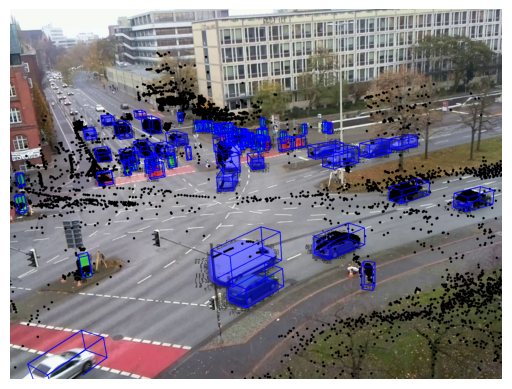

In [15]:
fig, ax = plt.subplots()
for i in range(100):
    time += 1. / cam.fps
    next_time = time + 1 / cam.fps
    index = int(np.floor(time * 10))
    next_index = int(np.floor(next_time * 10))
    if not lp.read_point_cloud(index):
        continue
    cam.set_frame(int(np.floor(time * cam.fps)), True)
    # Filter point cloud by frame time and foreground
    fb = filter.filter_background(lp.get_points_meta())
    id2 = filter.filter_points_by_time(lp.pc, time, next_time)
    id3 = np.intersect1d(fb[0], id2)
    cam.plot_point_cloud(lp.get_xyz()[id3, :], [1, 0, 0])
    # Read also next point cloud if frame interval reaches the next cloud
    if next_index - index > 0:
        if not lp.read_point_cloud(next_index):
            continue
        # Filter point cloud by frame time and foreground
        fb = filter.filter_background(lp.get_points_meta())
        id2 = filter.filter_points_by_time(lp.pc, time, next_time)
        id3 = np.intersect1d(fb[0], id2)
        cam.plot_point_cloud(lp.get_xyz()[id3, :], [1, 0, 0])
    # Interpolate bounding boxes to camera frame
    bb = lp.get_bounding_boxes_at(time)
    cam.plot_bounding_boxes_3D(bb, [255, 0, 0])
  
    # Show image in notebook
    ax.clear()
    ax.imshow(cv2.cvtColor(cam.img, cv2.COLOR_BGR2RGB))
    ax.axis('off')  # Hide axes
    display(fig)
    clear_output(wait=True)